In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    classification_report,
    roc_curve,
    roc_auc_score,
    f1_score
)

In [3]:
# Step 1: load data and step 2 (Explore)
titanic = sns.load_dataset('titanic')

In [6]:
titanic['survived'].value_counts()

survived
0    549
1    342
Name: count, dtype: int64

In [7]:
titanic['survived'].mean()

np.float64(0.3838383838383838)

In [8]:
# Step 3: Prepare Features

wanted_columns = ['pclass', 'sex', 'age', 'fare', 'survived']

titanic_for_model = titanic[wanted_columns]
titanic_for_model.head()

,pclass,sex,age,fare,survived
0,3,male,22.0,7.2500,0
1,1,female,38.0,71.2833,1
2,3,female,26.0,7.9250,1
3,1,female,35.0,53.1000,1
4,3,male,35.0,8.0500,0


In [9]:
titanic_for_model = titanic_for_model.dropna()
len(titanic_for_model) # new length after removing rows with missing values

714

In [10]:
mapping = {
    'male': 0,
    'female': 1
}
titanic_for_model['sex'] = titanic_for_model['sex'].map(mapping)

In [11]:
X = titanic_for_model[['pclass', 'sex', 'age', 'fare']]
y = titanic_for_model['survived']

In [13]:
X.head()

,pclass,sex,age,fare
0,3,0,22.0,7.2500
1,1,1,38.0,71.2833
2,3,1,26.0,7.9250
3,1,1,35.0,53.1000
4,3,0,35.0,8.0500


In [14]:
y.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

In [15]:
# 4. Scale

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [16]:
X_scaled[:5]

array([[ 0.91123237, -0.75905134, -0.53037664, -0.51897787],
       [-1.47636364,  1.31743394,  0.57183099,  0.69189675],
       [ 0.91123237,  1.31743394, -0.25482473, -0.50621356],
       [-1.47636364,  1.31743394,  0.36516706,  0.34804915],
       [ 0.91123237, -0.75905134,  0.36516706, -0.5038498 ]])

In [17]:
# 5. Split the data to train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
y_train.mean()

np.float64(0.4063047285464098)

In [19]:
y_test.mean()

np.float64(0.40559440559440557)

In [20]:
# 6 and 7: Train and make predictions
logistic_regression_model = LogisticRegression(max_iter=1000)
logistic_regression_model.fit(X_train, y_train)

y_prediction_logistic = logistic_regression_model.predict(X_test)

In [21]:
# 8: Evaluation

print(classification_report(y_test, y_prediction_logistic))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83        85
           1       0.75      0.72      0.74        58

    accuracy                           0.79       143
   macro avg       0.78      0.78      0.78       143
weighted avg       0.79      0.79      0.79       143



In [23]:
confusion_matrix_logistic = confusion_matrix(y_test, y_prediction_logistic)

<Axes: >

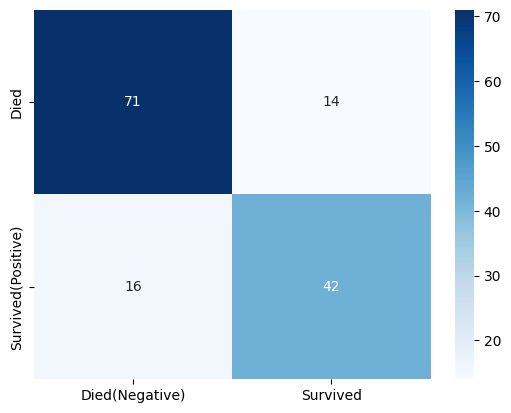

In [29]:
sns.heatmap(
    confusion_matrix_logistic,
    annot=True,
    cmap='Blues',
    xticklabels = ['Died(Negative)', 'Survived'],
    yticklabels = ['Died', 'Survived(Positive)']
)

In [30]:
y_probability_logistic = logistic_regression_model.predict_proba(X_test)
survived_probabilities = y_probability_logistic[:, 1] # Survived (1) column

In [33]:
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

for threshold in thresholds:

    y_prediction_threshold = (survived_probabilities >= threshold).astype(int) # [0,1,0...] - converth the True/False to 1/0

    accuracy = accuracy_score(y_test, y_prediction_threshold)
    precision = precision_score(y_test, y_prediction_threshold)
    recall = recall_score(y_test, y_prediction_threshold)
    # FPR - False Positive Rate (ROC related) - looks at our mistakes on the negative (0) class (how badly did we fail on the deaths?)
    print(f"THRESHOLD {threshold}:\n ACC - {accuracy:.2f}\n PRECISION - {precision:.2f}\n RECALL - {recall:.2f}")

THRESHOLD 0.3:
 ACC - 0.75
 PRECISION - 0.65
 RECALL - 0.83
THRESHOLD 0.4:
 ACC - 0.80
 PRECISION - 0.73
 RECALL - 0.83
THRESHOLD 0.5:
 ACC - 0.79
 PRECISION - 0.75
 RECALL - 0.72
THRESHOLD 0.6:
 ACC - 0.78
 PRECISION - 0.80
 RECALL - 0.62
THRESHOLD 0.7:
 ACC - 0.80
 PRECISION - 0.97
 RECALL - 0.53


In [38]:
# =============================================================================
# ROC CURVE - Calculate Values at All Thresholds
# =============================================================================

# roc_curve returns THREE arrays:
#   - false_positive_rates: FPR at each threshold (x-axis values)
#   - true_positive_rates:  TPR at each threshold (y-axis values)  
#   - thresholds:           The actual threshold values (from high to low)

false_positive_rates, true_positive_rates, thresholds = roc_curve(
    y_test,           # Actual labels (0 or 1)
    survived_probabilities    # Predicted probabilities (0.0 to 1.0)
)

# AUC = Area Under the ROC Curve (single number summarizing model quality)
# AUC = 1.0 means perfect model, AUC = 0.5 means random guessing
area_under_curve = roc_auc_score(y_test, survived_probabilities)

print("ROC Curve Data:")
print(f"  Number of threshold points: {len(thresholds)}")
print(f"  Threshold range: {thresholds.min():.3f} to {thresholds.max():.3f}")
print(f"  AUC (Area Under Curve): {area_under_curve:.3f}")

# Show a few example points
print("\nSample points on the ROC curve:")
print(f"{'Threshold':>12} {'TPR (Recall)':>15} {'FPR':>10}")
print("-" * 40)
sample_indices = [0, len(thresholds)//4, len(thresholds)//2, -1]
for idx in sample_indices:
    print(f"{thresholds[idx]:>12.3f} {true_positive_rates[idx]:>15.2%} {false_positive_rates[idx]:>10.2%}")

ROC Curve Data:
  Number of threshold points: 48
  Threshold range: 0.046 to inf
  AUC (Area Under Curve): 0.852

Sample points on the ROC curve:
   Threshold    TPR (Recall)        FPR
----------------------------------------
         inf           0.00%      0.00%
       0.590          63.79%     12.94%
       0.427          81.03%     20.00%
       0.046         100.00%    100.00%


In [43]:
area_under_curve # the higher the AUC - the better

0.8516227180527384

In [40]:
# =============================================================================
# AUTOMATIC THRESHOLD SELECTION - Two Methods
# =============================================================================

# =============================================================================
# METHOD 1: YOUDEN'S J STATISTIC
# =============================================================================
# Youden's J finds the threshold that MAXIMIZES the distance from random guessing
# Formula: J = TPR - FPR
# We want HIGH TPR (catch positives) and LOW FPR (few false alarms)
# So maximizing (TPR - FPR) gives us the best balance

youden_j_scores = true_positive_rates - false_positive_rates
optimal_index_youden = np.argmax(youden_j_scores)
optimal_threshold_youden = thresholds[optimal_index_youden]
optimal_tpr_youden = true_positive_rates[optimal_index_youden]
optimal_fpr_youden = false_positive_rates[optimal_index_youden]

print("="*65)
print("AUTOMATIC THRESHOLD SELECTION")
print("="*65)

print("\n📊 METHOD 1: Youden's J Statistic")
print("-"*65)
print("Formula: J = TPR - FPR  (maximize this value)")
print("Intuition: Find the point FURTHEST from the random guessing diagonal")
print(f"\n  ✓ Optimal threshold:     {optimal_threshold_youden:.3f}")
print(f"  ✓ Youden's J value:      {youden_j_scores[optimal_index_youden]:.3f}")
print(f"  ✓ TPR at this threshold: {optimal_tpr_youden:.2%}")
print(f"  ✓ FPR at this threshold: {optimal_fpr_youden:.2%}")

# =============================================================================
# METHOD 2: F1-SCORE OPTIMIZATION
# =============================================================================
# F1 Score = harmonic mean of Precision and Recall
# This balances both precision (don't cry wolf) and recall (catch all positives)

optimal_f1_score = 0
optimal_threshold_f1 = 0.5
optimal_precision_f1 = 0
optimal_recall_f1 = 0

# Try many threshold values
threshold_candidates = np.arange(0.05, 0.95, 0.01)

for threshold_candidate in threshold_candidates:
    predictions_at_threshold = (survived_probabilities >= threshold_candidate).astype(int)
    current_f1 = f1_score(y_test, predictions_at_threshold)
    
    if current_f1 > optimal_f1_score:
        optimal_f1_score = current_f1
        optimal_threshold_f1 = threshold_candidate
        optimal_precision_f1 = precision_score(y_test, predictions_at_threshold)
        optimal_recall_f1 = recall_score(y_test, predictions_at_threshold)

print("\n📊 METHOD 2: F1-Score Optimization")
print("-"*65)
print("Formula: F1 = 2 × (Precision × Recall) / (Precision + Recall)")
print("Intuition: Find the best balance between Precision and Recall")
print(f"\n  ✓ Optimal threshold:     {optimal_threshold_f1:.3f}")
print(f"  ✓ Best F1 score:         {optimal_f1_score:.2%}")
print(f"  ✓ Precision at optimal:  {optimal_precision_f1:.2%}")
print(f"  ✓ Recall at optimal:     {optimal_recall_f1:.2%}")

# =============================================================================
# COMPARE WITH DEFAULT THRESHOLD (0.5)
# =============================================================================
predictions_default = (survived_probabilities >= 0.5).astype(int)
default_precision = precision_score(y_test, predictions_default)
default_recall = recall_score(y_test, predictions_default)
default_f1 = f1_score(y_test, predictions_default)

print("\n📊 COMPARISON: Default Threshold (0.5)")
print("-"*65)
print(f"  • Precision: {default_precision:.2%}")
print(f"  • Recall:    {default_recall:.2%}")
print(f"  • F1 Score:  {default_f1:.2%}")

AUTOMATIC THRESHOLD SELECTION

📊 METHOD 1: Youden's J Statistic
-----------------------------------------------------------------
Formula: J = TPR - FPR  (maximize this value)
Intuition: Find the point FURTHEST from the random guessing diagonal

  ✓ Optimal threshold:     0.401
  ✓ Youden's J value:      0.616
  ✓ TPR at this threshold: 82.76%
  ✓ FPR at this threshold: 21.18%

📊 METHOD 2: F1-Score Optimization
-----------------------------------------------------------------
Formula: F1 = 2 × (Precision × Recall) / (Precision + Recall)
Intuition: Find the best balance between Precision and Recall

  ✓ Optimal threshold:     0.390
  ✓ Best F1 score:         77.42%
  ✓ Precision at optimal:  72.73%
  ✓ Recall at optimal:     82.76%

📊 COMPARISON: Default Threshold (0.5)
-----------------------------------------------------------------
  • Precision: 75.00%
  • Recall:    72.41%
  • F1 Score:  73.68%


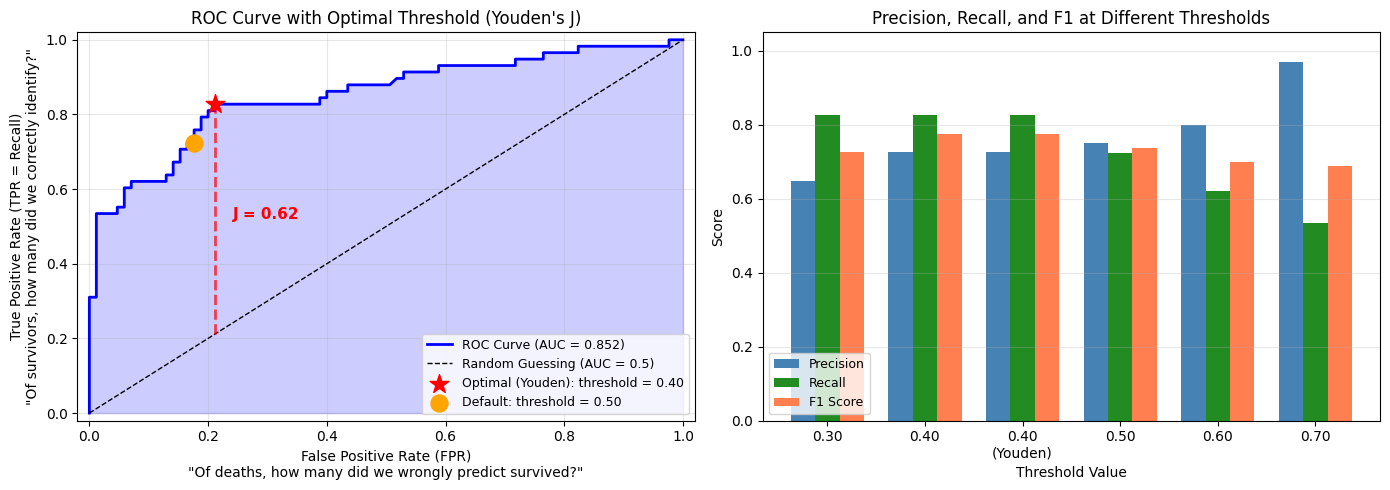


THRESHOLD COMPARISON TABLE
Threshold          Precision       Recall     F1 Score   Notes
---------------------------------------------------------------------------
0.30                  64.86%       82.76%       72.73%   
0.40                  72.73%       82.76%       77.42%   
0.40                  72.73%       82.76%       77.42%   ← OPTIMAL (Youden's J)
0.50                  75.00%       72.41%       73.68%   ← Default
0.60                  80.00%       62.07%       69.90%   
0.70                  96.88%       53.45%       68.89%   


In [42]:
# =============================================================================
# VISUALIZE: ROC Curve with Optimal Threshold Marked
# =============================================================================

figure, (axis_roc, axis_comparison) = plt.subplots(1, 2, figsize=(14, 5))

# -----------------------------------------------------------------------------
# LEFT PLOT: ROC Curve with Optimal Threshold
# -----------------------------------------------------------------------------

# Plot the ROC curve
axis_roc.plot(
    false_positive_rates, 
    true_positive_rates, 
    'b-', 
    linewidth=2, 
    label=f'ROC Curve (AUC = {area_under_curve:.3f})'
)

# Plot the random guessing diagonal
axis_roc.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Guessing (AUC = 0.5)')

# Fill the area under the curve
axis_roc.fill_between(false_positive_rates, true_positive_rates, alpha=0.2, color='blue')

# Mark the OPTIMAL threshold (Youden's J)
axis_roc.scatter(
    [optimal_fpr_youden], 
    [optimal_tpr_youden], 
    c='red', s=200, zorder=5, marker='*',
    label=f'Optimal (Youden): threshold = {optimal_threshold_youden:.2f}'
)

# Mark the DEFAULT threshold (0.5)
index_default_threshold = np.argmin(np.abs(thresholds - 0.5))
axis_roc.scatter(
    [false_positive_rates[index_default_threshold]], 
    [true_positive_rates[index_default_threshold]], 
    c='orange', s=150, zorder=5,
    label=f'Default: threshold = 0.50'
)

# Draw vertical line showing Youden's J distance from diagonal
diagonal_y_at_optimal_fpr = optimal_fpr_youden  # On diagonal, y = x
axis_roc.plot(
    [optimal_fpr_youden, optimal_fpr_youden], 
    [diagonal_y_at_optimal_fpr, optimal_tpr_youden], 
    'r--', linewidth=2, alpha=0.7
)
axis_roc.annotate(
    f'J = {youden_j_scores[optimal_index_youden]:.2f}', 
    xy=(optimal_fpr_youden + 0.03, (diagonal_y_at_optimal_fpr + optimal_tpr_youden) / 2),
    fontsize=11, color='red', fontweight='bold'
)

axis_roc.set_xlabel('False Positive Rate (FPR)\n"Of deaths, how many did we wrongly predict survived?"', fontsize=10)
axis_roc.set_ylabel('True Positive Rate (TPR = Recall)\n"Of survivors, how many did we correctly identify?"', fontsize=10)
axis_roc.set_title('ROC Curve with Optimal Threshold (Youden\'s J)', fontsize=12)
axis_roc.legend(loc='lower right', fontsize=9)
axis_roc.grid(True, alpha=0.3)
axis_roc.set_xlim([-0.02, 1.02])
axis_roc.set_ylim([-0.02, 1.02])

# -----------------------------------------------------------------------------
# RIGHT PLOT: Compare Metrics at Different Thresholds
# -----------------------------------------------------------------------------

thresholds_to_compare = [0.3, 0.4, optimal_threshold_youden, 0.5, 0.6, 0.7]
threshold_display_labels = []
precision_values = []
recall_values = []
f1_values = []

for threshold_value in thresholds_to_compare:
    predictions_at_threshold = (survived_probabilities >= threshold_value).astype(int)
    
    precision_at_threshold = precision_score(y_test, predictions_at_threshold)
    recall_at_threshold = recall_score(y_test, predictions_at_threshold)
    f1_at_threshold = f1_score(y_test, predictions_at_threshold)
    
    precision_values.append(precision_at_threshold)
    recall_values.append(recall_at_threshold)
    f1_values.append(f1_at_threshold)
    
    # Create display label
    if threshold_value == optimal_threshold_youden:
        threshold_display_labels.append(f'{threshold_value:.2f}\n(Youden)')
    else:
        threshold_display_labels.append(f'{threshold_value:.2f}')

# Create grouped bar chart
x_positions = np.arange(len(thresholds_to_compare))
bar_width = 0.25

bars_precision = axis_comparison.bar(
    x_positions - bar_width, precision_values, bar_width, 
    label='Precision', color='steelblue'
)
bars_recall = axis_comparison.bar(
    x_positions, recall_values, bar_width, 
    label='Recall', color='forestgreen'
)
bars_f1 = axis_comparison.bar(
    x_positions + bar_width, f1_values, bar_width, 
    label='F1 Score', color='coral'
)

axis_comparison.set_xlabel('Threshold Value', fontsize=10)
axis_comparison.set_ylabel('Score', fontsize=10)
axis_comparison.set_title('Precision, Recall, and F1 at Different Thresholds', fontsize=12)
axis_comparison.set_xticks(x_positions)
axis_comparison.set_xticklabels(threshold_display_labels)
axis_comparison.legend(loc='lower left', fontsize=9)
axis_comparison.set_ylim(0, 1.05)
axis_comparison.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# Print Comparison Table
# -----------------------------------------------------------------------------
print("\n" + "="*75)
print("THRESHOLD COMPARISON TABLE")
print("="*75)
print(f"{'Threshold':<15} {'Precision':>12} {'Recall':>12} {'F1 Score':>12}   Notes")
print("-"*75)

for i, threshold_value in enumerate(thresholds_to_compare):
    note = ""
    if threshold_value == optimal_threshold_youden:
        note = "← OPTIMAL (Youden's J)"
    elif threshold_value == 0.5:
        note = "← Default"
    
    print(f"{threshold_value:<15.2f} {precision_values[i]:>12.2%} {recall_values[i]:>12.2%} {f1_values[i]:>12.2%}   {note}")

In [45]:
false_positive_rates, true_positive_rates, thresholds = roc_curve(
    y_test,
    survived_probabilities
)

In [48]:
true_positive_rates

array([0.        , 0.01724138, 0.31034483, 0.31034483, 0.53448276,
       0.53448276, 0.55172414, 0.55172414, 0.60344828, 0.60344828,
       0.62068966, 0.62068966, 0.63793103, 0.63793103, 0.67241379,
       0.67241379, 0.70689655, 0.70689655, 0.72413793, 0.72413793,
       0.75862069, 0.75862069, 0.79310345, 0.79310345, 0.81034483,
       0.81034483, 0.82758621, 0.82758621, 0.84482759, 0.84482759,
       0.86206897, 0.86206897, 0.87931034, 0.87931034, 0.89655172,
       0.89655172, 0.9137931 , 0.9137931 , 0.93103448, 0.93103448,
       0.94827586, 0.94827586, 0.96551724, 0.96551724, 0.98275862,
       0.98275862, 1.        , 1.        ])

In [ ]:
thresholds_to_check = [0.3, 0.4, 0.5, 0.6, 0.7]

tpr_values = []
fpr_values = []

for threshold in thresholds_to_check:
    index = np.argmin(thresholds - threshold)

In [50]:
fpr, tpr, thresholds = roc_curve(y_test, survived_probabilities)
j_scores = tpr - fpr
best_t = thresholds[np.argmax(j_scores)]

In [51]:
best_t

np.float64(0.4014034331212748)

In [53]:
np.argmax(j_scores)

np.int64(26)

In [52]:
j_scores

array([0.        , 0.01724138, 0.31034483, 0.29858012, 0.52271805,
       0.48742394, 0.50466531, 0.49290061, 0.54462475, 0.53286004,
       0.55010142, 0.49127789, 0.50851927, 0.49675456, 0.53123732,
       0.51947262, 0.55395538, 0.54219067, 0.55943205, 0.54766734,
       0.5821501 , 0.5703854 , 0.60486815, 0.59310345, 0.61034483,
       0.59858012, 0.6158215 , 0.43935091, 0.45659229, 0.44482759,
       0.46206897, 0.42677485, 0.44401623, 0.37342799, 0.37890467,
       0.36713996, 0.38438134, 0.32555781, 0.34279919, 0.21338742,
       0.2306288 , 0.18356998, 0.20081136, 0.14198783, 0.15922921,
       0.00628803, 0.02352941, 0.        ])

In [54]:
thresholds

array([       inf, 0.95817406, 0.83247744, 0.8272355 , 0.70978006,
       0.69152773, 0.66807641, 0.65514154, 0.65091302, 0.64283779,
       0.62532814, 0.59728417, 0.58987298, 0.58080489, 0.5645789 ,
       0.56252822, 0.55332257, 0.54677078, 0.54388264, 0.49706905,
       0.49243436, 0.48323909, 0.46332496, 0.43134178, 0.42699988,
       0.40659801, 0.40140343, 0.24016823, 0.24005499, 0.23945547,
       0.23733963, 0.21988478, 0.21609952, 0.17626256, 0.17322385,
       0.15630424, 0.1516859 , 0.11730092, 0.11339668, 0.09275269,
       0.09039497, 0.08665947, 0.08665906, 0.07818855, 0.07733168,
       0.06350357, 0.06131925, 0.04621007])